# Ploteo de modelos (refactor)

Notebook refactorizado para evitar estar comentando código: selección de modelos por filtros + carga cacheada + bloques reutilizables.

In [23]:
import os
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import plot_utils as pu
import pot_utils as pot


In [24]:
import importlib, plot_utils_old_enero as pu
importlib.reload(pu)

<module 'plot_utils_old_enero' from '/home/jovyan/workspace/jl/cerro_blanco/SETUP_B/plot_utils_old_enero.py'>

## 1) Configuración general

In [25]:
# Carpeta donde están tus modelos (por defecto, el directorio actual del notebook)
BASE_DIR = str(Path(os.getcwd()) / "Chamber_Temp")
print("BASE_DIR =", BASE_DIR)

# --- Descubrimiento: include/exclude opcional por patrones glob ---
# Ejemplos:
#   INCLUDE = ["Depth_*_steady-state_*"]       # solo esos
#   EXCLUDE = ["*_test_*", "*old*"]            # excluir por patrón
INCLUDE = "Temp_*"
EXCLUDE = None

# --- Filtros por metadata parseada del nombre ---
# Dejá vacío/None para no filtrar.
KEEP_TEMPS  = None          # p.ej. [700, 750, 800]
KEEP_DEPTHS = None          # p.ej. [-10.0, -12.0] o [2.0, 4.0] según tu naming
KEEP_RES    = ["256x256"]          # p.ej. ["256x256", "512x512"]
KEEP_RADIUS = None          # p.ej. [4, 5, 6]

SORT_BY = "temp"              # "depth" | "temp" | "res" | "radius" | None

# --- Labels automáticos ---
# field: "temp" | "depth" | "res" | "radius" | "name"
LABEL_FIELD = "temp"
LABEL_FMT   = None          # p.ej. "{depth} km" o "{temp}°C"
LABEL_OVERRIDES = {}        # p.ej. {"Depth_2.0_*": "2 km"} (mejor usar match exacto)

BASE_DIR = /home/jovyan/workspace/jl/cerro_blanco/SETUP_B/Chamber_Temp


In [26]:
ALL_MODELS = pu.discover_model_dirs(BASE_DIR, include=INCLUDE, exclude=EXCLUDE)
MODEL_DIRS = pu.select_models(
    ALL_MODELS,
    temps=KEEP_TEMPS,
    depths=KEEP_DEPTHS,
    res=KEEP_RES,
    radius=KEEP_RADIUS,
    sort_by=SORT_BY,
)

if not MODEL_DIRS:
    raise SystemExit("No quedaron modelos después de filtrar. Revisá INCLUDE/EXCLUDE y KEEP_*.")

print("Modelos seleccionados:")
for d in MODEL_DIRS:
    meta = pu.parse_model_name(d)
    print(" -", d, meta)

LABEL_MAP = pu.make_label_map(MODEL_DIRS, field=LABEL_FIELD, fmt=LABEL_FMT, overrides=LABEL_OVERRIDES)


Modelos seleccionados:
 - Temp_700_steady-state_256x256 {'name': 'Temp_700_steady-state_256x256', 'temp': 700, 'res': '256x256'}
 - Temp_750_steady-state_256x256 {'name': 'Temp_750_steady-state_256x256', 'temp': 750, 'res': '256x256'}
 - Temp_800_steady-state_256x256 {'name': 'Temp_800_steady-state_256x256', 'temp': 800, 'res': '256x256'}
 - Temp_850_steady-state_256x256 {'name': 'Temp_850_steady-state_256x256', 'temp': 850, 'res': '256x256'}
 - Temp_900_steady-state_256x256 {'name': 'Temp_900_steady-state_256x256', 'temp': 900, 'res': '256x256'}
 - Temp_950_steady-state_256x256 {'name': 'Temp_950_steady-state_256x256', 'temp': 950, 'res': '256x256'}


In [20]:
LABEL_MAP = {
    "Depth_2.0": "2 km",
    "Depth_2.5": "2.5 km",
    "Depth_4.0": "4 km",
    "Depth_6.0": "6 km",
    "Depth_8.0": "8 km",
    "Depth_10.0": "10 km",
    "Depth_12.0": "12 km",
    "Depth_14.0": "14 km",
}

In [21]:
LABEL_MAP = {
    "R_3": "5 km",
    "R_4": "7 km",
    "R_5": "9 km",
    "R_6": "11 km",
    "R_7": "13 km",
}

In [22]:
LABEL_MAP = {
    "Pulse_070": "70 ka",
    "Pulse_100": "100 ka",
    "Pulse_150": "150 ka",
    "Pulse_200": "200 ka",
    "Pulse_250": "250 ka",
}

## 2) Perfil vertical a un timestep (midline + binning)

In [27]:
# Elegí timestep y parámetros del perfil
TIMESTEP = 107       # timestep objetivo
TOL_X    = 0.005   # 0.5% del ancho (midline)
NBINS    = 50     # bins verticales

DATA = {}
for dname in MODEL_DIRS:
    mdir = os.path.join(BASE_DIR, dname)
    x, z, T, ts_used = pu.load_xzT(mdir, TIMESTEP, m_to_km=1e-3, temp_offset=273.15)  # Kelvin->°C
    DATA[dname] = {"x": x, "z": z, "T": T, "ts": ts_used}
    try:
        t_val = pu.load_time(mdir, TIMESTEP, time_unit=1.0)
    except Exception:
        t_val = np.nan
    print(f"{dname}: N={len(T)}  timestep={ts_used}  time={t_val}")

Temp_700_steady-state_256x256: N=66049  timestep=103  time=0.9900000000000018
Temp_750_steady-state_256x256: N=66049  timestep=103  time=0.9900000000000018
Temp_800_steady-state_256x256: N=66049  timestep=103  time=0.9900000000000018
Temp_850_steady-state_256x256: N=66049  timestep=103  time=0.9900000000000018
Temp_900_steady-state_256x256: N=66049  timestep=103  time=0.9900000000000018
Temp_950_steady-state_256x256: N=66049  timestep=103  time=0.9900000000000018


In [28]:
profiles = {}
for dname, d in DATA.items():
    x, z, T = d["x"], d["z"], d["T"]
    mask = pu.midline_mask(x, z, tol_rel=TOL_X)
    z_line, T_line = z[mask], T[mask]
    zc, T_prof = pu.binned_profile(z_line, T_line, nbins=NBINS)
    profiles[dname] = {"zc": zc, "T_prof": T_prof}

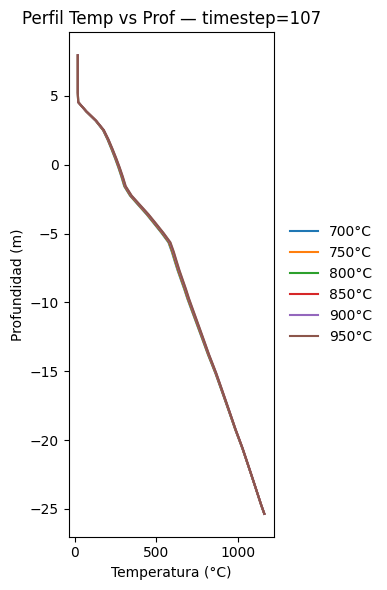

In [29]:
# Plot perfil
fig, ax = plt.subplots(figsize=(4,6))

for dname in MODEL_DIRS:
    pr = profiles[dname]
    ax.plot(pr["T_prof"], 1000 * pr["zc"], label=pu.resolve_label(dname, LABEL_MAP))

ax.set_xlabel("Temperatura (°C)")
ax.set_ylabel("Profundidad (m)")
ax.set_title(f"Perfil Temp vs Prof — timestep={TIMESTEP}")
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

fig.tight_layout()
plt.show()

AVISO: no encontré timestep cerca de 1000 ka (mejor: 990.00 ka, ts=103)


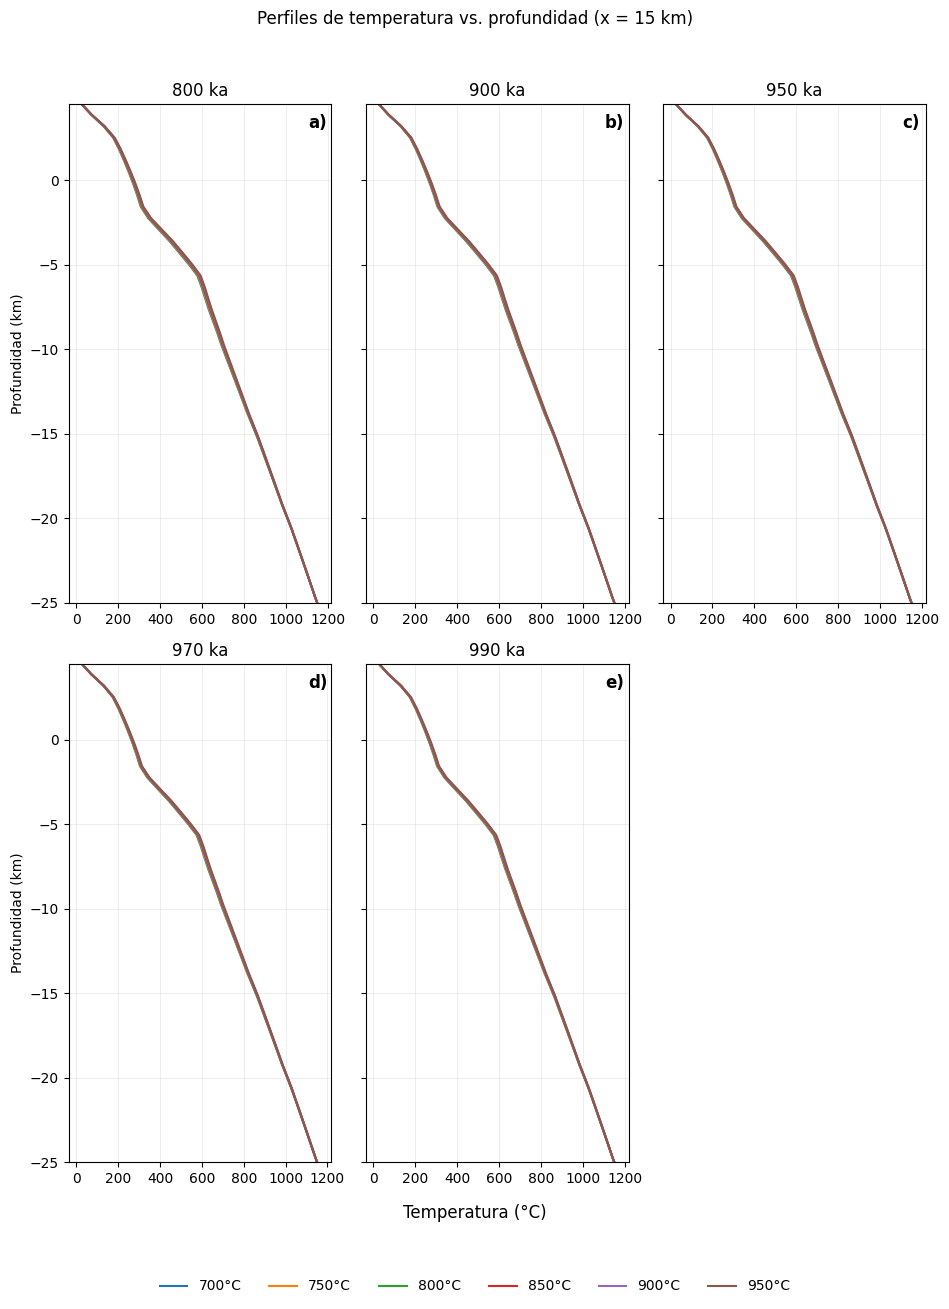

In [30]:
# Asumiendo que ya tenés:
# MODEL_DIRS (lista de paths/strings a modelos)
# LABEL_MAP  (dict dir->label generado por pu.make_label_map)

fig, axes, sel_ts, ts_to_tka = pu.plot_profiles_grid(
    MODEL_DIRS,
    LABEL_MAP,
    select_ka=[1000-200, 1000-100, 1000-50, 1000-30, 1000-10, 1000],
    base_dir=BASE_DIR,   # <-- clave
    tol_x=TOL_X,
    nbins=NBINS,
    ncols=3,
)

plt.show()


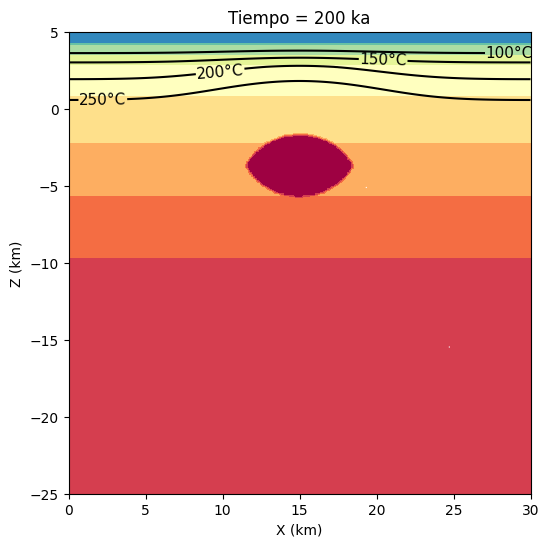

In [55]:
MODEL_DIR  = 'Chamber_Temp/Temp_950_steady-state_256x256'
target_ka = 200


idxs = pu.timestep_indices_in(MODEL_DIR)
tka = np.array([pu.load_time(MODEL_DIR, ts, time_unit=1.0)*1000.0 for ts in idxs])

i0 = int(np.argmin(np.abs(tka - target_ka)))
ts_sel = int(idxs[i0])
t_sel  = float(tka[i0])

fig, ax = pu.plot_section_projmat_isotherms_velocity_ts(
    MODEL_DIR,
    ts=ts_sel,
    temp_pattern="temperature-{ts}.h5",
    projmat_pattern="projMaterialField-{ts}.h5",
    vel_pattern="velocityField-{ts}.h5",
    isotherms=(100,150,200,250),
    title=f"Tiempo = {t_sel:.0f} ka",
    xlim=(0, 30),
    ylim=(5, -25),   # geológico, NO hace falta invertir
    quiver_step=20000,
    quiver_scale=4e-1,
)
plt.show()

## 3) Series temporales (carga cacheada)

In [13]:
# Parámetros de diagnóstico / grilla
ISOS = [100, 150, 200, 250]
vetana = (2.0, 4.0)        # ventana (km) para T_mean
X_CAM = 15.0              # km (centro de cámara, en tu sistema)
DX_CAM = 10.0             # km (ventana ±)

SERIES = {}
for d in MODEL_DIRS:
    SERIES[d] = pu.load_timeseries_for_model_cached(
        os.path.join(BASE_DIR, d),
        isotherms=ISOS,
        z_win_mean=vetana,
        z_for_q=2,
        time_to_ka=1e-3,
        time_field_prefer="timeField",
        x_cam=X_CAM,
        dx_cam=DX_CAM,
        step_every=1,
        ts_min=0,
        ts_max=None,
        m_to_km=1.0,
        force = True,
    )

# sanity
print("Cargadas series:", len(SERIES))

Cargadas series: 5


In [14]:
# Serie local (encima de la cámara): reusar el mismo plot_iso_depths sin tocar la función
SERIES_CAM = {}
for k, s in SERIES.items():
    s2 = dict(s)
    s2["iso_depths"] = s["iso_depths_cam"]
    SERIES_CAM[k] = s2

In [15]:
# Suavizado para iso_depths (regional)
SERIES_ISO_SMOOTH = {}
for name, s in SERIES.items():
    s2 = dict(s)
    iso2 = {}
    for Tiso, y in s["iso_depths"].items():
        iso2[Tiso] = pu.smooth_1d_nan_savgol(y, window=15, poly=2).tolist()
    s2["iso_depths"] = iso2
    SERIES_ISO_SMOOTH[name] = s2

In [16]:
# Suavizado para paneles T_mean y q (si los necesitás)
SERIES_SMOOTH = {}
for name, s in SERIES.items():
    s2 = dict(s)
    s2["T_mean_0_2km"] = pu.smooth_1d_nan_savgol(s["T_mean_0_2km"], window=11, poly=2).tolist()

    q_med = pu.smooth_1d_nan_median(s["q_at_z"], k=9)
    q_smooth = pu.smooth_1d_nan_savgol(q_med, window=11, poly=2)
    s2["q_at_z"] = q_smooth.tolist()

    SERIES_SMOOTH[name] = s2

## 4) Figuras típicas

In [17]:
import importlib, plot_utils as pu
importlib.reload(pu)

<module 'plot_utils' from '/home/jovyan/workspace/cerro_blanco/SETUP_B/plot_utils.py'>

In [18]:
T = float(ISOS[0])
name0 = next(iter(SERIES.keys()))
z = np.asarray(SERIES[name0]["iso_depths"][T], float)
print("ejemplo z min/max:", np.nanmin(z), np.nanmax(z))


ejemplo z min/max: 3.593521492183827 3.6692892533918666


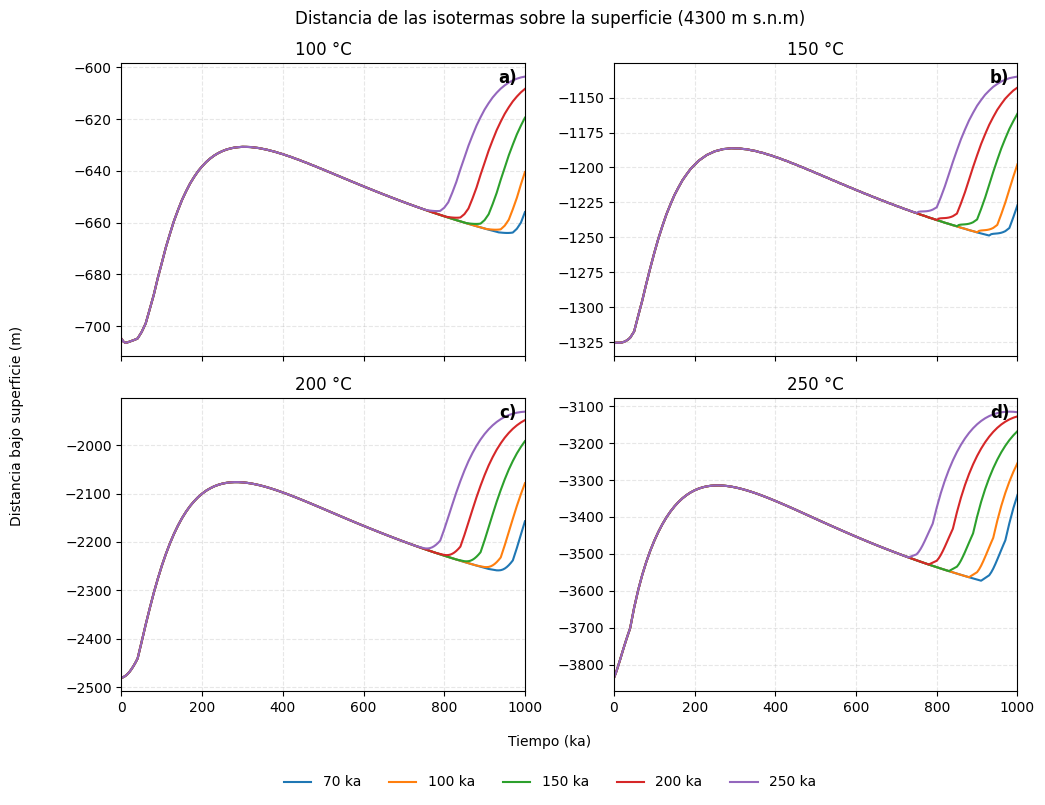

In [19]:
# Profundidad media de isotermas (regional)
fig1, ax1 = pu.plot_iso_depths(
    SERIES,
    ISOS,
    figsize=(10,8),
    label_map=LABEL_MAP,
    legend_ncol=8,
    xlim=(0, 1000),
)
fig1.suptitle("Distancia de las isotermas sobre la superficie (4300 m s.n.m)", y=1.02)
plt.show()

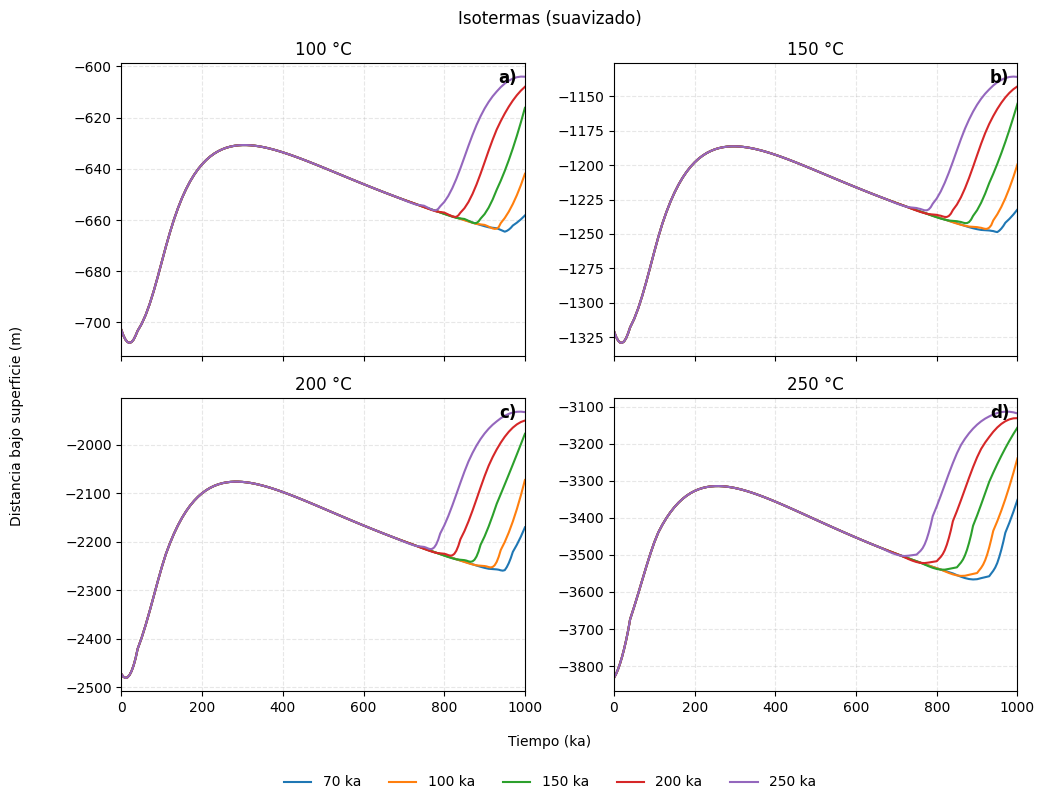

In [20]:
# Profundidad media de isotermas (regional, suavizado)
fig1, ax1 = pu.plot_iso_depths(
    SERIES_ISO_SMOOTH,
    ISOS,
    figsize=(10,8),
    label_map=LABEL_MAP,
    legend_ncol=8,
    xlim=(0, 1000),
    
)
fig1.suptitle("Isotermas (suavizado)", y=1.02)
plt.show()

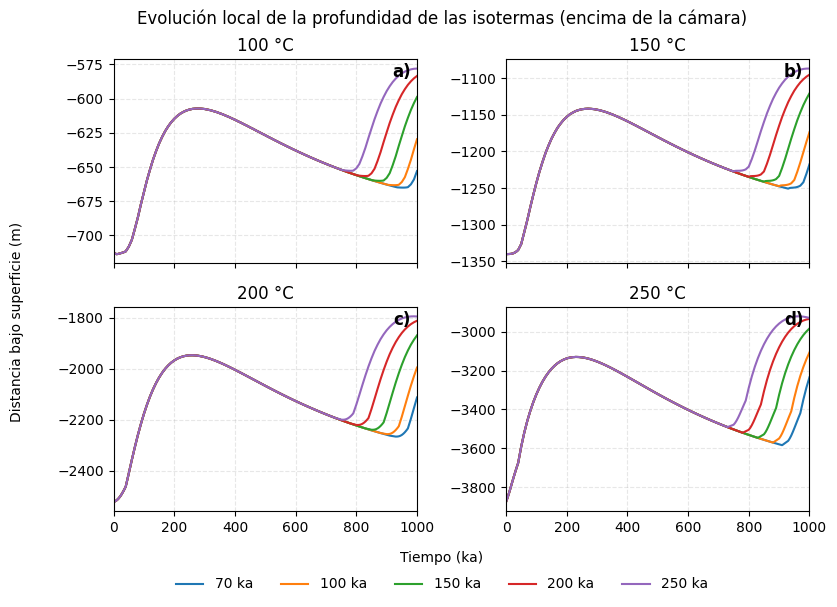

In [21]:
# Profundidad media de isotermas encima de la cámara (local)
fig2, ax2 = pu.plot_iso_depths(
    SERIES_CAM,
    ISOS,
    figsize=(8,6),
    label_map=LABEL_MAP,
    legend_ncol=6
)
fig2.suptitle("Evolución local de la profundidad de las isotermas (encima de la cámara)", y=1.02)
plt.show()

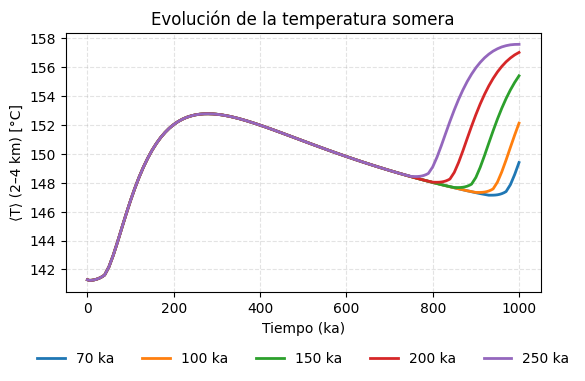

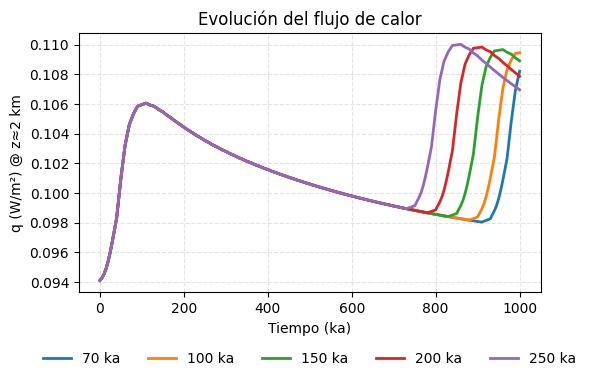

In [22]:
# Temperatura media 0–2 km
pu.plot_series_line(
    SERIES,
    "T_mean_0_2km",
    "⟨T⟩ (2–4 km) [°C]",
    title="Evolución de la temperatura somera",
    label_map=LABEL_MAP,
    legend_loc="bottom"
)
plt.show()

# Flujo de calor a z≈2 km
pu.plot_series_line(
    SERIES,
    "q_at_z",
    "q (W/m²) @ z≈2 km",
    title="Evolución del flujo de calor",
    label_map=LABEL_MAP,
    legend_loc="bottom"
)
plt.show()

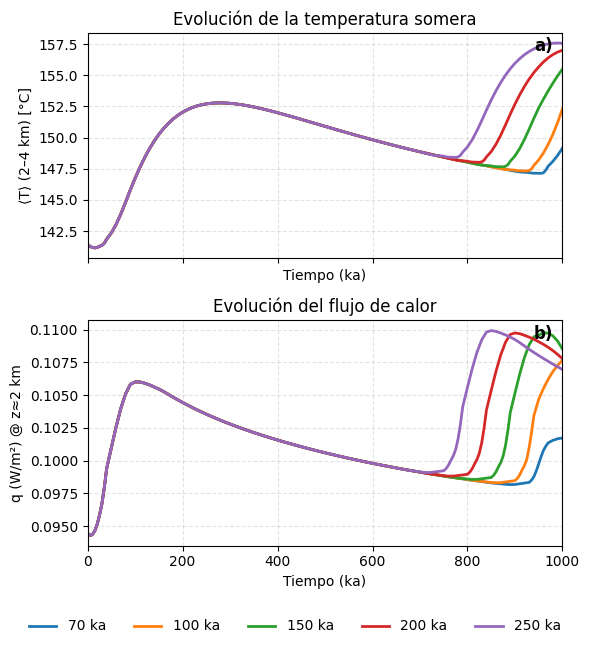

In [23]:
# Dos paneles apilados con una sola leyenda (recomendado para paper)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), sharex=True)

pu.plot_series_line(
    SERIES_SMOOTH, "T_mean_0_2km",
    "⟨T⟩ (2–4 km) [°C]",
    title="Evolución de la temperatura somera",
    label_map=LABEL_MAP,
    legend_loc="none",
    ax=ax1,
    panel_label="a)"
)

pu.plot_series_line(
    SERIES_SMOOTH, "q_at_z",
    "q (W/m²) @ z≈2 km",
    title="Evolución del flujo de calor",
    label_map=LABEL_MAP,
    legend_loc="none",
    ax=ax2,
    panel_label="b)"
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=6, frameon=False, bbox_to_anchor=(0.5, 0.02))
ax2.set_xlim(0, 1000)

fig.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

In [24]:
import h5py

def show_h5(path, n=200):
    out=[]
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            out.append((name, obj.shape, str(obj.dtype)))
    with h5py.File(path,'r') as f:
        f.visititems(visitor)
    for row in out[:n]:
        print(row)

#show_h5("Chamber_Temp/Temp_700_steady-state_256x256/temperature-0.h5")
show_h5("Chamber_Temp/Temp_700_steady-state_256x256/mesh.h5")

('en_map', (65536, 4), 'int32')
('vertices', (66049, 2), 'float64')


/opt/venv/lib64/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/venv/lib64/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


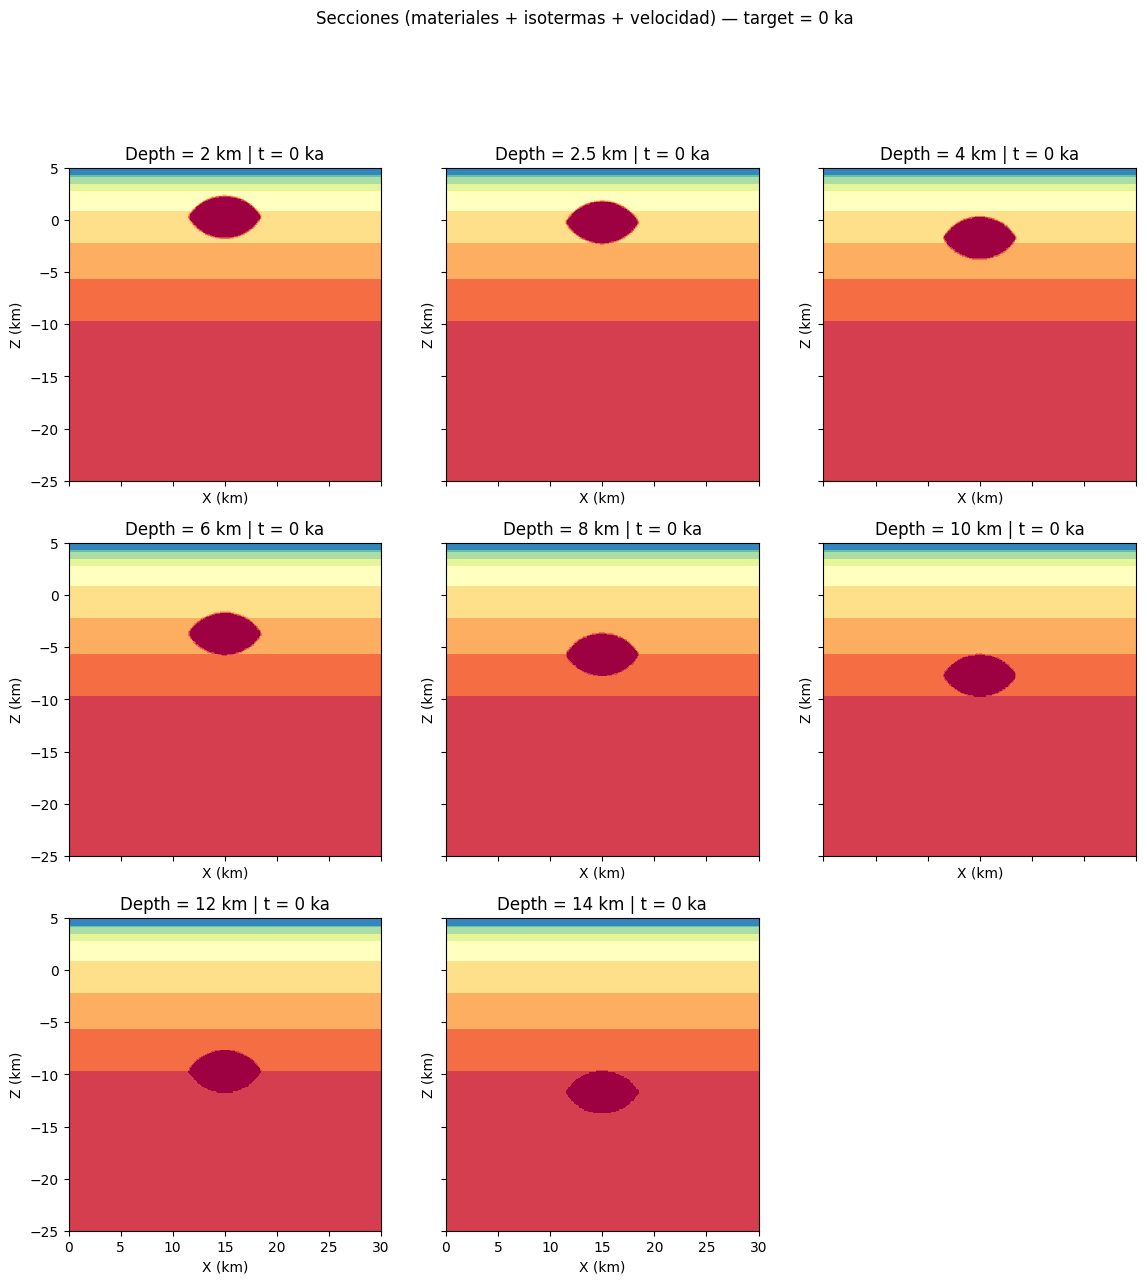

Guardado: Chamber_Depth/Fig_all_depths_sections_targetka0.png
Guardado: Chamber_Depth/Fig_all_depths_sections_targetka0.pdf


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.colors as mcolors

import plot_utils as pu  # o el import que uses vos

# ----------------------------
# CONFIG
# ----------------------------
BASE_DIR   = "Chamber_Depth"
target_ka  = 0.0

isotherms = () #(100, 150, 200, 250)
xlim = (0, 30)
ylim = (5, -25)       # como tu ejemplo
quiver_step  = 12
quiver_scale = 0 #4e-4

OUTPNG = os.path.join(BASE_DIR, "Fig_all_depths_sections_targetka0.png")
OUTPDF = os.path.join(BASE_DIR, "Fig_all_depths_sections_targetka0.pdf")

# ----------------------------
# Helper: elegir ts por target_ka (como tu snippet)
# ----------------------------
def select_ts_by_target_ka(model_dir, target_ka=0.0):
    idxs = pu.timestep_indices_in(model_dir)
    if not idxs:
        raise RuntimeError(f"No hay timesteps en {model_dir}")
    tka = np.array([pu.load_time(model_dir, ts, time_unit=1.0)*1000.0 for ts in idxs])
    i0 = int(np.argmin(np.abs(tka - float(target_ka))))
    return int(idxs[i0]), float(tka[i0])

# ----------------------------
# Helper: plot “sobre ax” (derivado de tu función)
# ----------------------------
def plot_section_on_ax(
    ax,
    model_dir: str,
    ts: int,
    *,
    isotherms=(100,150,200,250),
    mesh_pattern="mesh.h5",
    temp_pattern="temperature-{ts}.h5",
    projmat_pattern="projMaterialField-{ts}.h5",
    vel_pattern="velocityField-{ts}.h5",
    temp_offset=273.15,
    cmap_material="Spectral_r",
    levels=None,           # si lo pasás, fuerza niveles comunes entre paneles
    norm=None,             # idem
    quiver_step=12,
    quiver_scale=1e-5,
    quiver_width=0.0030,
    quiver_alpha=1.0,
    iso_color="k",
    iso_lw=1.3,
    iso_alpha=1.0,
    iso_label=False,
    title=None,
    xlim=None,
    ylim=None,
):
    # --- mesh coords ---
    mesh_xy = pu.h5_read_first(os.path.join(model_dir, mesh_pattern), keys=("vertices","data","coordinates"))
    x_raw = mesh_xy[:, 0].astype(float)
    z_raw = mesh_xy[:, -1].astype(float)

    # detectar si coords están en m o km
    Lx = float(np.nanmax(x_raw) - np.nanmin(x_raw))
    to_km = 1e-3 if Lx > 1000.0 else 1.0

    x = x_raw * to_km
    z = z_raw * to_km

    # convención: z negativa hacia abajo
    if np.nanmedian(z) > 0:
        z = -z

    tri = mtri.Triangulation(x, z)

    # --- temperature ---
    T = pu.h5_read_first(pu.file_for_ts(model_dir, temp_pattern, ts), keys=("data",)).ravel().astype(float)
    if np.nanmin(T) > 150.0:  # heurística que ya usás
        T = T - temp_offset

    # --- proj material ---
    matp = pu.h5_read_first(pu.file_for_ts(model_dir, projmat_pattern, ts), keys=("data",)).ravel()
    matp_i = np.rint(matp).astype(int)
    if matp_i.size != x.size:
        raise RuntimeError(
            f"projMaterial size ({matp_i.size}) != n_vertices mesh ({x.size}) en {model_dir} ts={ts}"
        )

    ids = np.unique(matp_i)
    ids = np.sort(ids)

    # niveles y norm comunes (opcional)
    if levels is None:
        levels_local = np.arange(ids.min() - 0.5, ids.max() + 1.5, 1.0)
        cmap = plt.get_cmap(cmap_material, len(ids))
        norm_local = mcolors.BoundaryNorm(levels_local, ncolors=len(ids))
    else:
        levels_local = levels
        cmap = plt.get_cmap(cmap_material, int(len(levels_local) - 1))
        norm_local = norm if norm is not None else mcolors.BoundaryNorm(levels_local, ncolors=int(len(levels_local) - 1))

    ax.tricontourf(tri, matp_i, levels=levels_local, cmap=cmap, norm=norm_local)

    # --- velocity ---
    u, w = pu.read_velocity_mesh(model_dir, ts, pattern=vel_pattern)
    u = u * to_km
    w = w * to_km

    idx = np.arange(0, x.size, max(1, int(quiver_step)))
    while idx.size > 2500:
        quiver_step = int(np.ceil(quiver_step * 1.3))
        idx = np.arange(0, x.size, quiver_step)

    ax.quiver(
        x[idx], z[idx], u[idx], w[idx],
        color="w",
        angles="xy",
        scale_units="xy",
        scale=quiver_scale,
        width=quiver_width,
        alpha=quiver_alpha
    )

    # isotermas
    iso_vals = [float(v) for v in isotherms]
    cs = ax.tricontour(tri, T, levels=iso_vals, colors=iso_color, linewidths=iso_lw, alpha=iso_alpha)
    if iso_label:
        fmt = {lv: f"{int(lv)}°C" for lv in iso_vals}
        ax.clabel(cs, cs.levels, inline=True, fontsize=9, fmt=fmt)

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Z (km)")
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_aspect("equal", adjustable="box")
    if title is not None:
        ax.set_title(title)

    # mantener tu convención (en tu función original invertías yaxis al final)
    ax.invert_yaxis()

    return levels_local, norm_local

# ----------------------------
# 1) Descubrir modelos Depth_* y ordenarlos por depth numérico
# ----------------------------
all_dirs = pu.discover_model_dirs(BASE_DIR, include=["Depth_*"])
depth_dirs = pu.select_models(all_dirs, sort_by="depth")  # usa regex Depth_<float>
model_dirs = [os.path.join(BASE_DIR, d) for d in depth_dirs]

if not model_dirs:
    raise RuntimeError(f"No encontré modelos en {BASE_DIR} con patrón Depth_*")

# ----------------------------
# 2) (Opcional pero recomendable) fijar niveles de materiales globales
#    así todos los paneles usan el mismo “mapeo” discreto.
# ----------------------------
# Tomo ids del primer modelo al ts más cercano (robusto y simple)
ts0, _ = select_ts_by_target_ka(model_dirs[0], target_ka=target_ka)
mat0 = pu.h5_read_first(pu.file_for_ts(model_dirs[0], "projMaterialField-{ts}.h5", ts0), keys=("data",)).ravel()
ids0 = np.sort(np.unique(np.rint(mat0).astype(int)))
global_levels = np.arange(ids0.min() - 0.5, ids0.max() + 1.5, 1.0)
global_norm   = mcolors.BoundaryNorm(global_levels, ncolors=int(len(global_levels) - 1))

# ----------------------------
# 3) Plot grid
# ----------------------------
n = len(model_dirs)
ncols = 3  # ajustá a gusto
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols, 4.6*nrows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

for i, (ax, mdir) in enumerate(zip(axes, model_dirs)):
    ts_sel, t_sel = select_ts_by_target_ka(mdir, target_ka=target_ka)

    meta = pu.parse_model_name(os.path.basename(mdir))
    depth = meta.get("depth", None)
    depth_txt = f"{depth:g} km" if depth is not None else os.path.basename(mdir)

    plot_section_on_ax(
        ax, mdir, ts_sel,
        isotherms=isotherms,
        xlim=xlim, ylim=ylim,
        quiver_step=quiver_step,
        quiver_scale=quiver_scale,
        iso_label=False,  # si querés, ponelo True en 1 panel para no ensuciar
        levels=global_levels,
        norm=global_norm,
        title=f"Depth = {depth_txt} | t = {t_sel:.0f} ka"
    )

# apagar ejes sobrantes
for j in range(len(model_dirs), len(axes)):
    axes[j].axis("off")

fig.suptitle(f"Secciones (materiales + isotermas + velocidad) — target = {target_ka:.0f} ka", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])

fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, dpi=300, bbox_inches="tight")
plt.show()

print("Guardado:", OUTPNG)
print("Guardado:", OUTPDF)


/opt/venv/lib64/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/venv/lib64/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/venv/lib64/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/venv/lib64/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


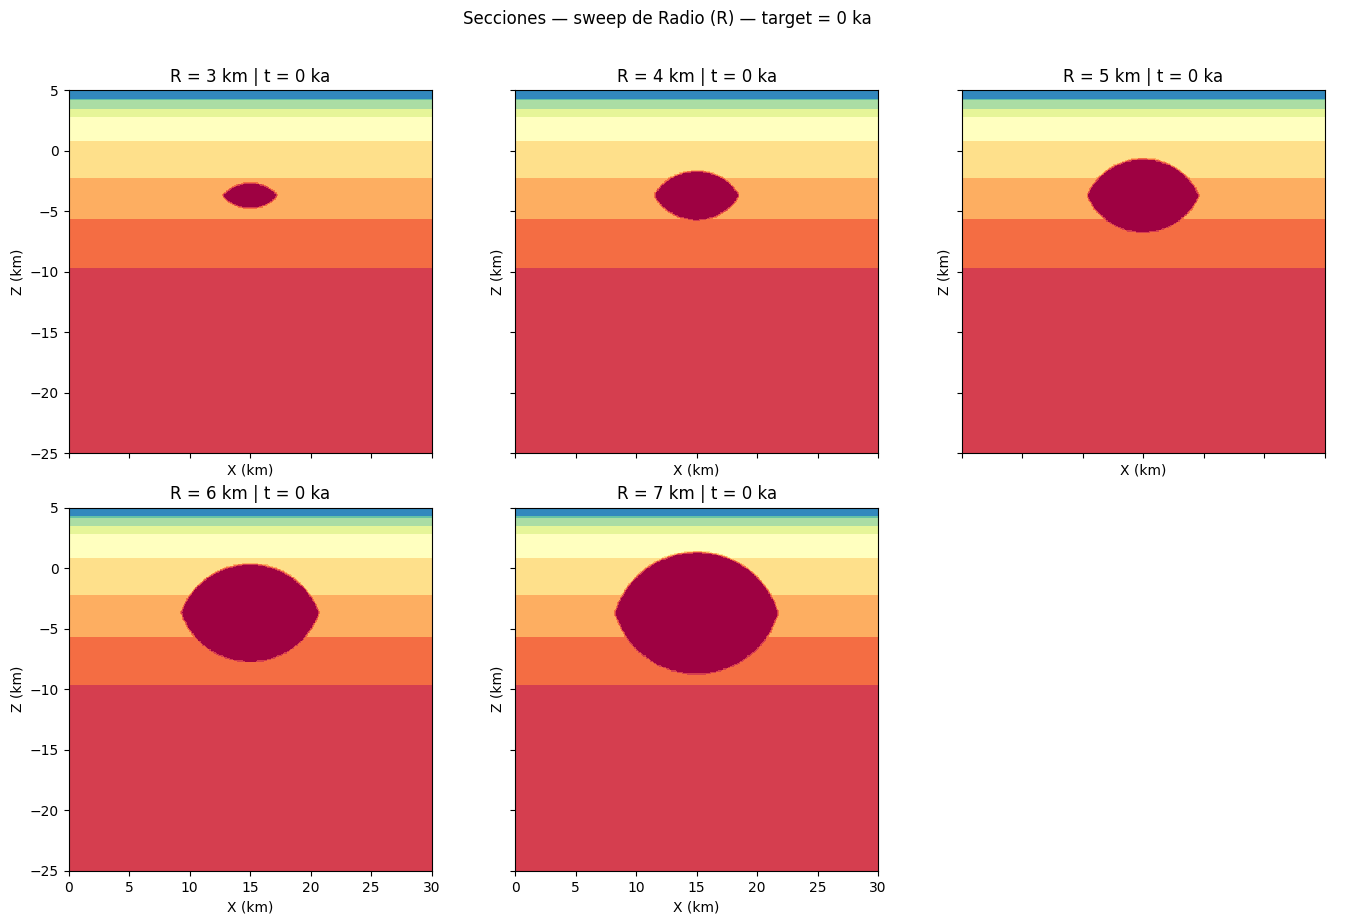

Guardado: Chamber_Radius/Fig_all_R_sections_targetka0.png
Guardado: Chamber_Radius/Fig_all_R_sections_targetka0.pdf


In [11]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.colors as mcolors

import plot_utils as pu

# ----------------------------
# CONFIG
# ----------------------------
BASE_DIR   = "Chamber_Radius"     # carpeta donde están R_7_..., R_6_...
target_ka  = 0.0

isotherms = ()#(100, 150, 200, 250)
xlim = (0, 30)
ylim = (5, -25)
quiver_step  = 12
quiver_scale = 0

OUTPNG = os.path.join(BASE_DIR, "Fig_all_R_sections_targetka0.png")
OUTPDF = os.path.join(BASE_DIR, "Fig_all_R_sections_targetka0.pdf")

# ----------------------------
# ts por target_ka
# ----------------------------
def select_ts_by_target_ka(model_dir, target_ka=0.0):
    idxs = pu.timestep_indices_in(model_dir)
    if not idxs:
        raise RuntimeError(f"No hay timesteps en {model_dir}")
    tka = np.array([pu.load_time(model_dir, ts, time_unit=1.0)*1000.0 for ts in idxs])
    i0 = int(np.argmin(np.abs(tka - float(target_ka))))
    return int(idxs[i0]), float(tka[i0])

# ----------------------------
# parse R desde nombre carpeta tipo: R_7_steady-state_256x256
# ----------------------------
def parse_R(name: str):
    m = re.search(r"(?:^|/)R_([0-9]*\.?[0-9]+)(?:_|$)", name)
    return float(m.group(1)) if m else None

# ----------------------------
# plot “sobre ax” (tu función; igual que antes)
# ----------------------------
def plot_section_on_ax(
    ax,
    model_dir: str,
    ts: int,
    *,
    isotherms=(100,150,200,250),
    mesh_pattern="mesh.h5",
    temp_pattern="temperature-{ts}.h5",
    projmat_pattern="projMaterialField-{ts}.h5",
    vel_pattern="velocityField-{ts}.h5",
    temp_offset=273.15,
    cmap_material="Spectral_r",
    levels=None,
    norm=None,
    quiver_step=12,
    quiver_scale=1e-5,
    quiver_width=0.0030,
    quiver_alpha=1.0,
    iso_color="k",
    iso_lw=1.3,
    iso_alpha=1.0,
    iso_label=False,
    title=None,
    xlim=None,
    ylim=None,
):
    mesh_xy = pu.h5_read_first(os.path.join(model_dir, mesh_pattern), keys=("vertices","data","coordinates"))
    x_raw = mesh_xy[:, 0].astype(float)
    z_raw = mesh_xy[:, -1].astype(float)

    Lx = float(np.nanmax(x_raw) - np.nanmin(x_raw))
    to_km = 1e-3 if Lx > 1000.0 else 1.0

    x = x_raw * to_km
    z = z_raw * to_km
    if np.nanmedian(z) > 0:
        z = -z

    tri = mtri.Triangulation(x, z)

    T = pu.h5_read_first(pu.file_for_ts(model_dir, temp_pattern, ts), keys=("data",)).ravel().astype(float)
    if np.nanmin(T) > 150.0:
        T = T - temp_offset

    matp = pu.h5_read_first(pu.file_for_ts(model_dir, projmat_pattern, ts), keys=("data",)).ravel()
    matp_i = np.rint(matp).astype(int)
    if matp_i.size != x.size:
        raise RuntimeError(f"projMaterial size ({matp_i.size}) != n_vertices ({x.size}) en {model_dir} ts={ts}")

    ids = np.sort(np.unique(matp_i))

    if levels is None:
        levels_local = np.arange(ids.min() - 0.5, ids.max() + 1.5, 1.0)
        cmap = plt.get_cmap(cmap_material, len(ids))
        norm_local = mcolors.BoundaryNorm(levels_local, ncolors=len(ids))
    else:
        levels_local = levels
        cmap = plt.get_cmap(cmap_material, int(len(levels_local) - 1))
        norm_local = norm if norm is not None else mcolors.BoundaryNorm(levels_local, ncolors=int(len(levels_local) - 1))

    ax.tricontourf(tri, matp_i, levels=levels_local, cmap=cmap, norm=norm_local)

    u, w = pu.read_velocity_mesh(model_dir, ts, pattern=vel_pattern)
    u = u * to_km
    w = w * to_km

    idx = np.arange(0, x.size, max(1, int(quiver_step)))
    while idx.size > 2500:
        quiver_step = int(np.ceil(quiver_step * 1.3))
        idx = np.arange(0, x.size, quiver_step)

    ax.quiver(
        x[idx], z[idx], u[idx], w[idx],
        color="w",
        angles="xy",
        scale_units="xy",
        scale=quiver_scale,
        width=quiver_width,
        alpha=quiver_alpha
    )

    iso_vals = [float(v) for v in isotherms]
    cs = ax.tricontour(tri, T, levels=iso_vals, colors=iso_color, linewidths=iso_lw, alpha=iso_alpha)
    if iso_label:
        fmt = {lv: f"{int(lv)}°C" for lv in iso_vals}
        ax.clabel(cs, cs.levels, inline=True, fontsize=9, fmt=fmt)

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Z (km)")
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_aspect("equal", adjustable="box")
    if title is not None:
        ax.set_title(title)

    ax.invert_yaxis()
    return levels_local, norm_local

# ----------------------------
# 1) Descubrir modelos R_* y ordenarlos por R
# ----------------------------
all_dirs = pu.discover_model_dirs(BASE_DIR, include=["R_*"])
if not all_dirs:
    raise RuntimeError(f"No encontré carpetas con patrón R_* dentro de {BASE_DIR}")

radius_dirs = sorted(all_dirs, key=lambda d: (parse_R(d) if parse_R(d) is not None else 1e9))
model_dirs = [os.path.join(BASE_DIR, d) for d in radius_dirs]

# ----------------------------
# 2) niveles globales materiales (del primer modelo)
# ----------------------------
ts0, _ = select_ts_by_target_ka(model_dirs[0], target_ka=target_ka)
mat0 = pu.h5_read_first(pu.file_for_ts(model_dirs[0], "projMaterialField-{ts}.h5", ts0), keys=("data",)).ravel()
ids0 = np.sort(np.unique(np.rint(mat0).astype(int)))
global_levels = np.arange(ids0.min() - 0.5, ids0.max() + 1.5, 1.0)
global_norm   = mcolors.BoundaryNorm(global_levels, ncolors=int(len(global_levels) - 1))

# ----------------------------
# 3) Plot grid
# ----------------------------
n = len(model_dirs)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols, 4.6*nrows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

for ax, mdir in zip(axes, model_dirs):
    ts_sel, t_sel = select_ts_by_target_ka(mdir, target_ka=target_ka)

    base = os.path.basename(mdir)
    R = parse_R(base)
    R_txt = f"{R:g}" if R is not None else base

    plot_section_on_ax(
        ax, mdir, ts_sel,
        isotherms=isotherms,
        xlim=xlim, ylim=ylim,
        quiver_step=quiver_step,
        quiver_scale=quiver_scale,
        iso_label=False,
        levels=global_levels,
        norm=global_norm,
        title=f"R = {R_txt} km | t = {t_sel:.0f} ka"
    )

for j in range(len(model_dirs), len(axes)):
    axes[j].axis("off")

fig.suptitle(f"Secciones — sweep de Radio (R) — target = {target_ka:.0f} ka", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])

fig.savefig(OUTPNG, dpi=300, bbox_inches="tight")
fig.savefig(OUTPDF, dpi=300, bbox_inches="tight")
plt.show()

print("Guardado:", OUTPNG)
print("Guardado:", OUTPDF)
